# Simple CSTR Control: NMPC
(By David T)

### 0. Introduction
In this example, the control of a simple CSTR reactor is demonstrated with the *CAPRESE* tools. For this model, a non-isothermal CSTR model is used. The kinetics represent the reaction between thiosulfate and hydrogen peroxide,
\begin{align}
\dfrac{dC_{A}}{dt} &= \dfrac{F}{V} \left(C_{A}^{in} - C_{A} \right) - 2k T_{R}C_{A}^{2} \\
\dfrac{dT_{R}}{dt} &= \dfrac{F}{V} \left(T_{R}^{in} - T_{R} \right) + \dfrac{2 \left(- \Delta H_{R} \right)k T_{R} C_{A}^{2}}{\rho C_{p}} - \dfrac{UA}{V \rho C_{p}} \left(T_{R} - T_{cw} \right) \\
\dfrac{dT_{cw}}{dt} &= \dfrac{F_{cw}}{V_{cw}} \left(T_{cw}^{in} - T_{cw} \right) + \dfrac{2 \left(- \Delta H_{R} \right)k T_{R} C_{A}^{2}}{\rho C_{p}} - \dfrac{UA}{V \rho C_{p}} \left(T_{R} - T_{cw} \right) \\
k \left(T_{R} \right) &= k_{0} \exp \left(\dfrac{-E_{a}}{RT_{R}} \right)
\end{align}
Where $C_{A}$ is the concentration of thiosulfate, $T_{R}$ is the reactor temperature and the cooling water temperature $T_{cw}$.  
For this problem, a simple NMPC strategy will be used, that is a formulation in the form:
 \begin{equation}
     \begin{split}
         \min_{\mathbf{u}_{k}} \quad & \varphi_{N} \left(x_{N|k}\right) +\sum_{i=0}^{N-1} \left[ x_{i|k}^{T}Q_{i}x_{i|k} + u_{i|k}^{T}R_{i}u_{i|k} \right]\\
         \text{s.t.} \quad &x_{l+1|k} = f \left(x_{l|k}, u_{l|k}\right) \\ & x_{0|k} = x \left(k\right) \\
         &x_{l|k} \in \mathbb{X}, \quad l \in \left\lbrace 0,1,...,N-1 \right\rbrace, \quad x_{N|k} \in \mathbb{X}_{f} \\
         &u_{l|k} \in \mathbb{U}, \quad l \in \left\lbrace 0,1,...,N-1 \right\rbrace,\\
     \end{split}
 \end{equation}
where, $x$ and $u$ correspond to states and controls.

### 1. Control object creation

In [2]:
from pyomo.environ import *
from sample_mods.cstr_rodrigo.cstr_c_nmpc import cstr_rodrigo_dae
from nmpc_mhe.pyomo_dae.NMPCGen_pyDAE import NmpcGen_DAE
from nmpc_mhe.aux.utils import load_iguess
from nmpc_mhe.aux.utils import reconcile_nvars_mequations
import matplotlib.pyplot as plt
import sys, os

As a pre-condition; the underlying model needs to be constructed, the names of the differential and control variables identified. For convenience, the control variables are declared with an equality to a dummy parameter, i.e. $\text{dummy} = u$. Instead of manipulating  u, *caprese* will look for dummy and replace it as necessary.  
If the initial step is already covered, then to create the *caprese* objects, states and controls need to be declared.

In [3]:
states = ["Ca", "T", "Tj"]  #: States

In [4]:
controls = ["u1"]  #: dummy controls
u_bounds = {"u1": (200, 1000)}  #: bounds

In [5]:
state_bounds = {"Ca": (0.0, None), "T":(2.0E+02, None), "Tj":(2.0E+02, None)}  #: bounds on the states

Then, the reference state for which the set-point of all the states is computed needs to be specified.

In [6]:
ref_state = {("Ca", (0,)): 0.010}

In [7]:
mod = cstr_rodrigo_dae(1, 1)  #: provide a model

Finally, the *caprese* object can be created.

In [8]:
e = NmpcGen_DAE(mod,
                2,
                states,
                controls,
                var_bounds=state_bounds,
                u_bounds=u_bounds,
                ref_state=ref_state,
                override_solver_check=True)

New model at 140109389983328
New timebounds defined!
New model at 140109389991040
New timebounds defined!
Model: unknown Bounds activated


### 2. Controller algorithm - set-up problem phase

Setting up the model, requires passing initial guesses to the models for control. These include *PlantSample*, *SteadyRef*, and *olnmp*.  
A series of subproblems is solved so that the data is passed between models. For example, *SteadyRef* -> *PlantSample* -> *olnmp*.

In [9]:
e.get_state_vars()  #: Fetch internal variables
e.load_iguess_steady()  #: find initial guess and solve steadyRef

{'Ca': [(0,)], 'T': [(0,)], 'Tj': [(0,)]}
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_steady_ref]]labels at 1568247290.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]SteadyRef.--------------------
/tmp/tmpe5_ona68.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                              bound_push = 1e-07                 yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247290.411233vanilla0  yes
            

optimal


In [10]:
load_iguess(e.SteadyRef, e.PlantSample, 0, 0)
e.create_nmpc()

Steady!
fetgt 1 0
These variables do not have the same number of Collocation points (ncp_t)
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
New model at 140109389853072
New timebounds defined!


W0[[Initializing NMPC]]With 5 fe and 3 cp.


In [11]:
e.solve_dyn(e.PlantSample)

e.find_target_ss()
e.create_suffixes_nmpc()
e.update_targets_nmpc()

e.compute_QR_nmpc(n=-1)
e.new_weights_olnmpc(1e-04, 1e+06)

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpgsow95zz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247290.532644vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint 

optimal
W0[[find_target_ss]]No reference state was given, using default.


                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.1937940e-03 1.82e-12 2.38e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  9.1786567e-03 4.65e-04 1.98e-02  -1.0 1.27e+00    -  9.90e-01 1.00e+00f  1 
   2  7.4981691e-03 6.50e+00 1.09e-02  -1.0 1.49e+02    -  1.00e+00 1.00e+00h  1 Nhj 
   3  1.4333990e-04 6.27e+02 3.09e+00  -1.0 2.77e+03    -  1.00e+00 5.00e-01h  2 
   4  1.3966651e-06 4.14e+02 8.51e-01  -1.0 2.36e+03    -  1.00e+00 1.00e+00h  1 
   5  1.5577639e-04 3.45e+02 1.81e+00  -1.0 3.01e+03    -  1.00e+00 5.00e-01h  2 
   6  4.8728216e-04 2.16e+02 3.38e-01

optimal


### 3. Controller algorithm - main controller loop

The main controller loop for this example calculates the set-point first if necessary. Then it basically:  
1. Simulates plant
2. Reads state
3. Initializes NMPC
4. Attempts to solve NMPC
5. Set initial conditions
6. Inject input

In [12]:
ca = e.PlantSample.Ca[2, 0]
t = e.PlantSample.T[2, 0]
u = e.PlantSample.u1[2]
spl = []
ul = []
cal = []
tl = []

In [13]:
for i in range(0, 200):
    if i in [30 * (j * 2) for j in range(0, 2)]:  #: set-point 1
        sp = 0.019
        ref_state = {("Ca", (0,)): sp}
        e.change_setpoint(ref_state=ref_state, keepsolve=False, wantparams=False, tag="sp")
        e.compute_QR_nmpc(n=-1)
        e.new_weights_olnmpc(1e-04, 1e+06)
    elif i in [30 * (j * 2 + 1) for j in range(0, 2)]:  #: set-point 2
        sp = 0.01
        ref_state = {("Ca", (0,)): sp}
        e.change_setpoint(ref_state=ref_state, keepsolve=False, wantparams=False, tag="sp")
        e.compute_QR_nmpc(n=-1)
        e.new_weights_olnmpc(1e-04, 1e+06)
    elif i > 101:  #: next set-points
        slope = (0.019 - 0.01)/100
        sp = 0.01 + slope * (i-100) 
        ref_state = {("Ca", (0,)): sp}
        e.change_setpoint(ref_state=ref_state, keepsolve=False, wantparams=False, tag="sp")
        e.compute_QR_nmpc(n=-1)
        e.new_weights_olnmpc(1e-04, 1e+06)
    spl.append(sp)
    e.solve_dyn(e.PlantSample, stop_if_nopt=True)  #: solve plant
    e.update_state_real()  # update the current state
    e.update_soi_sp_nmpc()
    cal.append(value(ca))
    tl.append(value(t))
    ul.append(value(u))
    e.preparation_phase_nmpc(as_strategy=False, make_prediction=False, plant_state=True)  #: initialize nmpc
    
    stat_nmpc = e.solve_dyn(e.olnmpc, skip_update=False, max_cpu_time=300,  #: Solve NMPC
                            jacobian_regularization_value=1e-04, tag="olnmpc",
                            keepsolve=False, wantparams=False)
    if stat_nmpc != 0:
        sys.exit()
    
    e.print_r_nmpc()
    e.update_u(e.olnmpc)  #: Get the resulting input for k+1
    e.cycleSamPlant(plant_step=True)  #:  Set up initial conditions of plant
    e.plant_uinject(e.PlantSample, src_kind="dict", skip_homotopy=True)  #: load input

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]SteadyRef2 (reference).--------------------
/tmp/tmpj8zqjyay.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality const

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247290.801491vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.0199684520516863		Current value \% \% 	 0.01919379397499582
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388926080
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp0kqtw0j6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.019 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.7327005863189697
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[plant_input]]Target 251.659242, Current 250.000000, n_steps 5.--------------------
Current Gap /\% 0.663697
-==--==--==--==--==--==--==--==--==--==--==--==--

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.07081447370098853		Current value \% \% 	 0.01901345471939946
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388956208
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I1[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpse7tx7wf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag =

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247291.660878vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.004885886497955893		Current value \% \% 	 0.019000928287851045
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389052896
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I2[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmph78xftxm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag =

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247291.933692vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I3[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpseggwwye.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpsx9sd8cq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247292.166450vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 2.2895926584091792e-05		Current value \% \% 	 0.019000004319643972
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388487648
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I4[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp_39vdxbb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpedujp6fy.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247292.392164vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5620763845015576e-06		Current value \% \% 	 0.01900000026621244
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388414320
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpopa5jfep.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I5[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.019 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.23797273635864258
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[plant_input]]Target 251.659242, Current 251.659242, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.0655893217133121e-07		Current value \% \% 	 0.018999999989664125
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388896448
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I6[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpqh2lea7y.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag =

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247292.880323vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp6vor4jcw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I7[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.019 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.23745489120483398
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[plant_input]]Target 251.659242, Current 251.659242, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I8[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp5cfjhpmg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag =

optimal


        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4735782e-24 3.31e+01 6.14e-17  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  6.7359417e-12 9.77e-11 1.78e-05  -1.0 3.31e+01    -  9.90e-01 1.00e+00h  1 
   2  6.7359417e-12 8.41e-12 1.04e-08  -1.0 7.81e-11    -  1.00e+00 1.00e+00h  1 Nhj 
   3  5.3897254e-15 7.50e-12 4.89e-09  -2.5 2.92e-08    -  1.00e+00 1.00e+00h  1 
   4  1.5192000e-17 6.14e-12 4.41e-09  -3.8 8.26e-10    -  1.00e+00 1.00e+00h  1 
   5  2.4342310e-21 8.19e-12 1.01e-09  -5.7 5.54e-11    -  1.00e+00 1.00e+00h  1 
   6  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.43e-11    -  1.00e+00 5.00e-01h  2 A
   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00e+00 7.81e-03h  8 A
   9  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
iter    objective    inf_

optimal


/tmp/tmpjw8mcszf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247293.341079vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 5.842731278965402e-10		Current value \% \% 	 0.01899999996952894
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388526688
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==--

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I9[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp4z76atoh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247293.586056vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 5.842731278965402e-10		Current value \% \% 	 0.01899999996952894
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388477456
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I10[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp0yoye67w.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4735782e-24 3.31e+01 6.14e-17  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  6.7359417e-12 9.77e-11 1.78e-05  -1.0 3.31e+01    -  9.90e-01 1.00e+00h  1 
   2  6.7359417e-12 8.41e-12 1.04e-08  -1.0 7.81e-11    -  1.00e+00 1.00e+00h  1 Nhj 
   3  5.3897254e-15 7.50e-12 4.89e-09  -2.5 2.92e-08    -  1.00e+00 1.00e+00h  1 
   4  1.5192000e-17 6.14e-12 4.41e-09  -3.8 8.26e-10    -  1.00e+00 1.00e+00h  1 
   5  2.4342310e-21 8.19e-12 1.01e-09  -5.7 5.54e-11    -  1.00e+00 1.00e+00h  1 
   6  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.43e-11    -  1.00e+00 5.00e-01h  2 A
   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00e+00 7.81e-03h  8 A
   9  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4

optimal


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247293.794789vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of var

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I11[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp4dyq5x7l.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


   2  6.7359417e-12 8.41e-12 1.04e-08  -1.0 7.81e-11    -  1.00e+00 1.00e+00h  1 Nhj 
   3  5.3897254e-15 7.50e-12 4.89e-09  -2.5 2.92e-08    -  1.00e+00 1.00e+00h  1 
   4  1.5192000e-17 6.14e-12 4.41e-09  -3.8 8.26e-10    -  1.00e+00 1.00e+00h  1 
   5  2.4342310e-21 8.19e-12 1.01e-09  -5.7 5.54e-11    -  1.00e+00 1.00e+00h  1 
   6  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.43e-11    -  1.00e+00 5.00e-01h  2 A
   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00e+00 7.81e-03h  8 A
   9  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  11  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  12  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  13  

optimal


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247293.997789vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of var

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 5.842731278965402e-10		Current value \% \% 	 0.01899999996952894
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389689472
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I12[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpu4dkg7_k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00e+00 7.81e-03h  8 A
   9  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  11  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  12  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  13  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  14  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  15  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.59e-11    -  1.00e+00 3.91e-03h  9 A
  16  5.7639686e-27 7.96e-12 4.52e-11  -8.6 1.59e-11    -  1.00e+00 1.00e+00w  1 

Number of Iterations....: 16

                                   (scaled)                

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247294.214456vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 5.842731278965402e-10		Current value \% \% 	 0.01899999996952894
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388600576
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I13[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpz9ql8div.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4735782e-24 3.31e+01 6.14e-17  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  6.7359417e-12 9.77e-11 1.78e-05  -1.0 3.31e+01    -  9.90e-01 1.00e+00h  1 
   2  6.7359417e-12 8.41e-12 1.04e-08  -1.0 7.81e-11    -  1.00e+00 1.00e+00h  1 Nhj 
   3  5.3897254e-15 7.50e-12 4.89e-09  -2.5 2.92e-08    -  1.00e+00 1.00e+00h  1 
   4  1.5192000e-17 6.14e-12 4.41e-09  -3.8 8.26e-10    -  1.00e+00 1.00e+00h  1 
   5  2.4342310e-21 8.19e-12 1.01e-09  -5.7 5.54e-11    -  1.00e+00 1.00e+00h  1 
   6  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.43e-11    -  1.00e+00 5.00e-01h  2 A
   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247294.430330vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I14[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp1t_ubcso.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00e+00 7.81e-03h  8 A
   9  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  11  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  12  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  13  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  14  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  15  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.59e-11    -  1.00e+00 3.91e-03h  9 A
  16  5.7639686e-27 7.96e-12 4.52e-11  -8.6 1.59e-11    -  1.00e+00 1.00e+00w  1 

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   5.7639686395553061e-27    5.763968639555306

optimal



                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247294.639285vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables....................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I15[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp2_m1vcoh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


   1  6.7359417e-12 9.77e-11 1.78e-05  -1.0 3.31e+01    -  9.90e-01 1.00e+00h  1 
   2  6.7359417e-12 8.41e-12 1.04e-08  -1.0 7.81e-11    -  1.00e+00 1.00e+00h  1 Nhj 
   3  5.3897254e-15 7.50e-12 4.89e-09  -2.5 2.92e-08    -  1.00e+00 1.00e+00h  1 
   4  1.5192000e-17 6.14e-12 4.41e-09  -3.8 8.26e-10    -  1.00e+00 1.00e+00h  1 
   5  2.4342310e-21 8.19e-12 1.01e-09  -5.7 5.54e-11    -  1.00e+00 1.00e+00h  1 
   6  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.43e-11    -  1.00e+00 5.00e-01h  2 A
   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00e+00 7.81e-03h  8 A
   9  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  11  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  12  2

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247294.847596vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I16[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmplbvrf49o.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4735782e-24 3.31e+01 6.14e-17  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  6.7359417e-12 9.77e-11 1.78e-05  -1.0 3.31e+01    -  9.90e-01 1.00e+00h  1 
   2  6.7359417e-12 8.41e-12 1.04e-08  -1.0 7.81e-11    -  1.00e+00 1.00e+00h  1 Nhj 
   3  5.3897254e-15 7.50e-12 4.89e-09  -2.5 2.92e-08    -  1.00e+00 1.00e+00h  1 
   4  1.5192000e-17 6.14e-12 4.41e-09  -3.8 8.26e-10    -  1.00e+00 1.00e+00h  1 
   5  2.4342310e-21 8.19e-12 1.01e-09  -5.7 5.54e-11    -  1.00e+00 1.00e+00h  1 
   6  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.43e-11    -  1.00e+00 5.00e-01h  2 A
   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247295.057570vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I17[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp1by77w0e.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4735782e-24 3.31e+01 6.14e-17  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  6.7359417e-12 9.77e-11 1.78e-05  -1.0 3.31e+01    -  9.90e-01 1.00e+00h  1 
   2  6.7359417e-12 8.41e-12 1.04e-08  -1.0 7.81e-11    -  1.00e+00 1.00e+00h  1 Nhj 
   3  5.3897254e-15 7.50e-12 4.89e-09  -2.5 2.92e-08    -  1.00e+00 1.00e+00h  1 
   4  1.5192000e-17 6.14e-12 4.41e-09  -3.8 8.26e-10    -  1.00e+00 1.00e+00h  1 
   5  2.4342310e-21 8.19e-12 1.01e-09  -5.7 5.54e-11    -  1.00e+00 1.00e+00h  1 
   6  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.43e-11    -  1.00e+00 5.00e-01h  2 A
   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00e+00 7.81e-03h  8 A
   9  2.4342310e-21 5.91e-12 3.42e-08  -8.6 

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247295.269551vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I18[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp5oy4c_99.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


   4  1.5192000e-17 6.14e-12 4.41e-09  -3.8 8.26e-10    -  1.00e+00 1.00e+00h  1 
   5  2.4342310e-21 8.19e-12 1.01e-09  -5.7 5.54e-11    -  1.00e+00 1.00e+00h  1 
   6  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.43e-11    -  1.00e+00 5.00e-01h  2 A
   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00e+00 7.81e-03h  8 A
   9  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  11  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  12  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  13  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  14  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  15  2.

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247295.476961vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpb5sjrgcy.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I19[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.019 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.23570656776428223
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[plant_input]]Target 251.659242, Current 251.659242, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 5.842731278965402e-10		Current value \% \% 	 0.01899999996952894
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387932688
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I20[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpeovk6vxa.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4735782e-24 3.31e+01 6.14e-17  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  6.7359417e-12 9.77e-11 1.78e-05  -1.0 3.31e+01    -  9.90e-01 1.00e+00h  1 
   2  6.7359417e-12 8.41e-12 1.04e-08  -1.0 7.81e-11    -  1.00e+00 1.00e+00h  1 Nhj 
   3  5.3897254e-15 7.50e-12 4.89e-09  -2.5 2.92e-08    -  1.00e+00 1.00e+00h  1 
   4  1.5192000e-17 6.14e-12 4.41e-09  -3.8 8.26e-10    -  1.00e+00 1.00e+00h  1 
   5  2.4342310e-21 8.19e-12 1.01e-09  -5.7 5.54e-11    -  1.00e+00 1.00e+00h  1 
   6  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.43e-11    -  1.00e+00 5.00e-01h  2 A
   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247295.928715vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I21[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpo0i0d8ps.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


   4  1.5192000e-17 6.14e-12 4.41e-09  -3.8 8.26e-10    -  1.00e+00 1.00e+00h  1 
   5  2.4342310e-21 8.19e-12 1.01e-09  -5.7 5.54e-11    -  1.00e+00 1.00e+00h  1 
   6  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.43e-11    -  1.00e+00 5.00e-01h  2 A
   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00e+00 7.81e-03h  8 A
   9  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  11  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  12  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  13  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  14  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  15  2.

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247296.142529vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp7iw15mr_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I22[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.019 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.2712712287902832
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[plant_input]]Target 251.659242, Current 251.659242, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 5.842731278965402e-10		Current value \% \% 	 0.01899999996952894
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387934448
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp6lo280ut.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I23[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.019 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.24955487251281738
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[plant_input]]Target 251.659242, Current 251.659242, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 5.842731278965402e-10		Current value \% \% 	 0.01899999996952894
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388117728
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmplhndgwq1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I24[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.019 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.23530888557434082
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[plant_input]]Target 251.659242, Current 251.659242, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I25[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp11bgmvfe.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmp21j5zd0y.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247297.135440vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 5.842731278965402e-10		Current value \% \% 	 0.01899999996952894
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388411040
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp9xilkmz3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I26[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.019 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.23679828643798828
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[plant_input]]Target 251.659242, Current 251.659242, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 5.842731278965402e-10		Current value \% \% 	 0.01899999996952894
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388340592
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I27[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpb46w4zj8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set

optimal


   5  2.4342310e-21 8.19e-12 1.01e-09  -5.7 5.54e-11    -  1.00e+00 1.00e+00h  1 
   6  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.43e-11    -  1.00e+00 5.00e-01h  2 A
   7  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.74e-11    -  1.00e+00 7.81e-03h  8 A
   8  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.69e-11    -  1.00e+00 7.81e-03h  8 A
   9  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  11  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  12  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  13  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  14  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.58e-11    -  1.00e+00 3.91e-03h  9 A
  15  2.4342310e-21 5.91e-12 3.42e-08  -8.6 1.59e-11    -  1.00e+00 3.91e-03h  9 A
  16  5

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247297.585216vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I28[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpj8saxc39.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpqzoh9roe.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247297.805998vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 5.842731278965402e-10		Current value \% \% 	 0.01899999996952894
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387955408
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I29[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpsb4jr9mw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmp55ceszhf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 111.111111 value 0.010000
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmptkr18fpf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247298.078266vanilla0  yes
                       print_info_string = yes                   ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 90.00000554398628		Current value \% \% 	 0.01899999996952894
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388710528
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I30[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpnil4_zme.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.6605416e+08 3.31e+01 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 
   1  2.9616672e+05 2.08e+03 1.57e+00  -1.0 2.26e+03    -  3.15e-01

optimal


                             output_file = 1568247298.294325vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequalit

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I31[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpko3z2obv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.168467

optimal


                                max_iter = 3000                  yes
                             output_file = 1568247298.504843vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequalit

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I32[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpmvematel.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.000000

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpnfj2_p69.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I33[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.01 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.23776912689208984
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[plant_input]]Target 364.870073, Current 364.870073, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.0014105988169911409		Current value \% \% 	 0.010000140752051214
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389683360
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I34[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmppc7b7ut3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmp_mqaosus.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247299.237842vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I35[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp8gu2dkt5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247299.495577vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 6.7254020743833855e-06		Current value \% \% 	 0.010000000364714044
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387494016
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I36[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp0vec47e_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247299.765419vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 4.6406067918035027e-07		Current value \% \% 	 0.009999999738579924
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387830048
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-

optimal



I37[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpavrjr366.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                           

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I37[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.01 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.24359846115112305
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[plant_input]]Target 364.870073, Current 364.870073, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I38[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp42u5hido.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


0.23734021186828613
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[plant_input]]Target 364.870073, Current 364.870073, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpfhofb_a5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000             

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 2.210384721131068e-09		Current value \% \% 	 0.009999999692394896
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387093808
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I39[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpz_zlh4al.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247300.493578vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5413018558506936e-10		Current value \% \% 	 0.00999999969218927
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387106816
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpiyzfrsis.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I40[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.01 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.237396240234375
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[plant_input]]Target 364.870073, Current 364.870073, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5413018558506936e-10		Current value \% \% 	 0.00999999969218927
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387533840
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpnwg_y_nv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I41[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.01 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.24427056312561035
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[plant_input]]Target 364.870073, Current 364.870073, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5413018558506936e-10		Current value \% \% 	 0.00999999969218927
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387291136
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I42[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpoeofm2yw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247301.246936vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.....................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I43[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp32hggr2w.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.139594

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247301.460329vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I44[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpebexaumv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.139594

optimal



                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247301.667571vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables....................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpgchl7uov.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I45[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.01 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.23248076438903809
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[plant_input]]Target 364.870073, Current 364.870073, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5413018558506936e-10		Current value \% \% 	 0.00999999969218927
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386875840
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp97c7ip9o.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I46[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.01 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.2873830795288086
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[plant_input]]Target 364.870073, Current 364.870073, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==--

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5413018558506936e-10		Current value \% \% 	 0.00999999969218927
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387430720
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I47[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp_cjhh8fo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247302.395460vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I48[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpctkz51hj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247302.606972vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of var

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5413018558506936e-10		Current value \% \% 	 0.00999999969218927
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387431520
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I49[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpr9e2wegi.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpie022xzy.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247302.897479vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5413018558506936e-10		Current value \% \% 	 0.00999999969218927
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388529408
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I50[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpmhjhhj62.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247303.114440vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I51[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpl6ei5a2m.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247303.320490vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I52[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpcabqthqj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247303.539982vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I53[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp67z8eyu9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247303.746392vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5413018558506936e-10		Current value \% \% 	 0.00999999969218927
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387429680
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I54[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp_pyl39ba.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247303.997601vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I55[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpialbezt7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247304.201326vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.....................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I56[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpc4ahkztl.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes


optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
To

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247304.408656vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I57[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpz4jr5gzj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set

optimal


This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1395941e-25 4.34e+03 1.69e-18  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y


optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247304.614435vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I58[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpxniat4tl.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247304.826771vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I59[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmppo_apn95.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes


optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:  

optimal


Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.0000003e-03 5.46e-12 7.25e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  9.0003247e-03 2.88e-06 8.77e-02  -1.0 1.94e-01    -  9.90e-0

optimal


/tmp/tmpk3b1yo1s.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247305.088976vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I60[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpof0vxjd4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.6605410e+08 4.34e+03 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 
   1  4.1665402e+04 3.36e+03 1.36e-01  -1.0 7.09e+03    -  8.41e-01 1.00e+00f  1 
   2  1.2820147e+01 8.61e+03 7.77e-06  -1.0 3.71e+03    -  1.00e+00 1.00e+00h  1 Nhj 
   3  1.8462140e-01 2.35e+0

optimal


                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247305.305735vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 4.688876522461154		Current value \% \% 	 0.018109112110706246
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386868768
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I61[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp0_5tvtbq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247305.515516vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I62[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpculj2d84.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247305.722813vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I63[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpuc2a4gca.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes


optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
To

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247305.928240vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I64[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpq3up94to.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247306.143790vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I65[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp53692n09.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247306.345292vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I66[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpel12z1ft.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes


optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
To

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247306.559872vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I67[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpuhbas3il.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247306.762876vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.....................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I68[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpuw6qu7h5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247306.967815vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.....................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 2.308405831696495e-09		Current value \% \% 	 0.018999998583120084
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389337856
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I69[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpjygt4jqc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247307.182906vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388591904
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I70[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpfwvmk9pa.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


/tmp/tmp1ja3cm07.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247307.403879vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388118768
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp90gl3b33.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I71[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.019 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.23740410804748535
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[plant_input]]Target 251.659253, Current 251.659253, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389614768
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I72[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp8nlolza1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpywutqgft.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247307.866303vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I73[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp87eckw_p.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.286012

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247308.078787vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpf897g3yt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I74[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.019 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.19627714157104492
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[plant_input]]Target 251.659253, Current 251.659253, n_steps 5.--------------------
Current Gap /\% 0.000000
-==--==--==--==--==--==--==--==--==--==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388853808
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I75[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpelb59eil.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247308.485044vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I76[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpqsukwv27.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        ineq

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247308.692329vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I77[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpx9l6zb_r.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247308.900853vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388545152
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I78[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpr6xcacf7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpg9h3fd6v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247309.180669vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387626848
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I79[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpri33mozm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpzln4jhjj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247309.409901vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387351936
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I80[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpgiosywrj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set

optimal


                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        ineq

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247309.626489vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387071648
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I81[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpocx5m29f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmp8_3pqy2f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247309.847942vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388602016
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I82[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpgv64qd6i.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247310.065521vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388617360
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I83[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpsp75ku6g.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247310.275271vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387275472
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I84[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmptp8h3zmn.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpykbkwbbo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247310.499660vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387829968
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I85[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp9b3oz5sg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247310.720427vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388116688
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I86[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpjityp3mm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.286012

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247310.936988vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.5519385180465058e-10		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388397696
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I87[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpag5motw7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247311.149478vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I88[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpmoufwh3e.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        ineq

optimal


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247311.360102vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of var

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I89[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpyzkybq8q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.9999986e-03 1.82e-12 2.34e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  8.9852637e-03 4.59e-04 2.07e-02  -1.0 1.28e+00    -  9.90e-01 1.00e+00f  1 
   2  7.3406870e-03 6.48e+00 1.07e-02  -1.0 1.50

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247311.609120vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 89.9999916839875		Current value \% \% 	 0.018999998583529194
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387073168
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I90[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp52jjzvrg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.660541

optimal


/tmp/tmpvzll3v76.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247311.828553vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 4.369293691359517		Current value \% \% 	 0.01043692904786003
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386950208
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--==

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I91[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpi916qd18.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


                                max_iter = 3000                  yes
                             output_file = 1568247312.080406vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequalit

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.2948782796494394		Current value \% \% 	 0.010029487519231136
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387351776
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-==--

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I92[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpxk3eus94.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set

optimal


                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        ineq

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247312.346165vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I93[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpoxro3aaf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247312.553531vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I94[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpr60gji3x.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpbcweoovh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247312.781207vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I95[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpgcbbvrf7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247312.996010vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I96[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpqus1feo6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247313.211601vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I97[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp1majv5mq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247313.423610vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 3.201631766669516e-08		Current value \% \% 	 0.009999999695375536
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387842336
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I98[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpkts_2f7c.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.932515

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247313.676002vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I99[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpnqzijcuf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_fl

optimal


                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247313.882388vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I100[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpz_jrvqgz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247314.091199vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I101[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp5npknn4_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247314.338270vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 1.768175848459015		Current value \% \% 	 0.009999999692189308
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388604432
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmphm254tn3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I102[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.01018 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.30631256103515625
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[plant_input]]Target 361.503396, Current 364.870073, n_steps 5.--------------------
Current Gap /\% 0.922706
-==--==--==--==--==--==--==--==--==-

optimal


/tmp/tmp_rs106vr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247314.664382vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I103[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp9nsq81l1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpahf446rn.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247315.028711vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.9390838630127595		Current value \% \% 	 0.010262710904430712
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387590464
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpkt0a1ric.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I104[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.01036 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.3350093364715576
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[plant_input]]Target 358.208099, Current 359.846997, n_steps 5.--------------------
Current Gap /\% 0.455443
-==--==--==--==--==--==--==--==--==--

/tmp/tmp0xe0elyk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpc_6sm1i_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247315.383721vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.9272395977429441		Current value \% \% 	 0.01035310345469118
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387590304
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpywf1o7cx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I105[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.010450000000000001 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.314190149307251
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[plant_input]]Target 356.586370, Current 358.208099, n_steps 5.--------------------
Current Gap /\% 0.452734
-==--==--==--==--==--==--

optimal


/tmp/tmp1nf_auqy.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247315.671195vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I106[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp_ie4kuvx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247315.921905vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.9112418085057366		Current value \% \% 	 0.01053313498804264
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388669968
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I107[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmprw7yb8a9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247316.177472vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.903580551849099		Current value \% \% 	 0.01062313615693823
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388834368
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I108[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpilaxsvp1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


/tmp/tmpb6g4b8my.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpuk21qf4a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247316.436265vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8960480473778523		Current value \% \% 	 0.010713137197985738
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389092976
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I109[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpkbgh33er.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total n

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 5351.519881 value 0.010900
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp49mlhbko.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247316.684239vanilla0  yes
                       print_info_string = yes                  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8886400416918349		Current value \% \% 	 0.01080313822717487
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387273472
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I110[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp_vmg6ykb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


/tmp/tmpbcwk1kk9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247316.933454vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8813534014897599		Current value \% \% 	 0.010893139252708635
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389412224
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I111[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp8pxmvrkt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247317.186034vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8741851631223627		Current value \% \% 	 0.010983140275272493
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386885712
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I112[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp3dpyhph5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
To

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247317.430884vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8671324631794246		Current value \% \% 	 0.01107314129502433
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389434544
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I113[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpj29n1s_q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247317.677183vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8601925301527243		Current value \% \% 	 0.011163142312082154
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389078608
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I114[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp42u51n0f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total n

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247317.926710vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8533626804990189		Current value \% \% 	 0.011253143326557375
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389434544
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I115[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp83kebseg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247318.181309vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8466403151581977		Current value \% \% 	 0.011343144338557288
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387350976
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I116[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmplz0x037v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.2616853e+06 3.01e+03 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 
 

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247318.427947vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8400229162430687		Current value \% \% 	 0.011433145348186572
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388965280
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I117[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpdy07gmna.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247318.681251vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8335080439091903		Current value \% \% 	 0.011523146355545733
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387429440
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I118[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp01aslbpu.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
To

optimal


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247318.928655vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.....................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.827093333338295		Current value \% \% 	 0.011613147360733152
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386881136
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I119[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp2bxq0g07.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


/tmp/tmp_6hxrivp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247319.184925vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8207764918942634		Current value \% \% 	 0.011703148363843063
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388353360
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I120[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpw_8dguca.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247319.432030vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8145552963756248		Current value \% \% 	 0.011793149364967415
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388135872
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I121[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp0dmhtu27.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247319.686184vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.8084275904109749		Current value \% \% 	 0.011883150364195438
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388117328
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I122[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpkcs0dtur.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.864115

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


/tmp/tmpi13r3xqv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247319.944811vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.802391281971089		Current value \% \% 	 0.011973151361613197
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388188480
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I123[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp8ybth482.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 5351.925541 value 0.012160
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpv1b0zkv5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247320.188777vanilla0  yes
                       print_info_string = yes                  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7964443409807489		Current value \% \% 	 0.01206315235730446
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387987456
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I124[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpbhawr1h9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247320.444306vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.790584797044283		Current value \% \% 	 0.012153153351350518
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387135088
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I125[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpkuf_h8xa.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


/tmp/tmp9r8v9kzc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247320.697028vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7848107372704407		Current value \% \% 	 0.012243154343830047
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387924896
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I126[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp1a6cnph8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


/tmp/tmpbbrs0hni.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247320.950519vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7791203041859001		Current value \% \% 	 0.012333155334819677
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389299296
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I127[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpveahy2id.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.335153

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247321.192294vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I128[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpn9lexp8z.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247321.441355vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7679831534312237		Current value \% \% 	 0.012513157312623566
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386883872
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I129[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp9cna5hoo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes


optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total n

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247321.695723vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7625329804061245		Current value \% \% 	 0.012603158299580038
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109390173520
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I130[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp9usshgvw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.391429

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247321.945854vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7571595197879777		Current value \% \% 	 0.012693159285330853
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388106400
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I131[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpuhwg3v0f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247322.191090vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7518611629600062		Current value \% \% 	 0.012783160269942294
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388615504
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I132[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpz3u01_86.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.282288

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247322.442863vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7466363459724618		Current value \% \% 	 0.01287316125347835
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388582416
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I133[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp4y2poea8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables..........................

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247322.689560vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7414835479984486		Current value \% \% 	 0.012963162236001389
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389143168
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I134[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp5ov2n922.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 5352.237035 value 0.013150
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpgix8luih.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247322.928031vanilla0  yes
                       print_info_string = yes                  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.736401289856337		Current value \% \% 	 0.013053163217572394
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388312656
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I135[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpdam_vzqq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


/tmp/tmp6a8o2vds.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpa8mucls6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247323.211197vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7313881325981394		Current value \% \% 	 0.013143164198250476
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388187520
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I136[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpe1rp3iq9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpkg6s9zgw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247323.549688vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7264426761526269		Current value \% \% 	 0.01323316517809268
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389429088
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I137[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpuznfi9mc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes


optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:  

optimal


/tmp/tmpof8pbm9y.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 5352.321317 value 0.013420
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp1eqf8xxa.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247323.834544vanilla0  yes
                       print_info_string = yes                  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I138[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpwe1np9y1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of u

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
To

optimal


/tmp/tmp3n9zdt9a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 5352.349364 value 0.013510
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp3jk1nv1k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247324.109728vanilla0  yes
                       print_info_string = yes                  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.716749451992429		Current value \% \% 	 0.013413167135492295
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386590160
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I139[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpjhl8ciyo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes


optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total n

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


/tmp/tmp3e0sqhf6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247324.401561vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7119990670200578		Current value \% \% 	 0.013503168113156916
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388169296
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpqbx90r39.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I140[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.013600000000000001 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.2401435375213623
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[plant_input]]Target 308.608726, Current 309.784180, n_steps 5.--------------------
Current Gap /\% 0.379443
-==--==--==--==--==--==-

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247324.644308vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.7073111459857414		Current value \% \% 	 0.013593169090200514
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389804560
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I141[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpa8z35atv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.829919

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247324.899220vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.702684464628903		Current value \% \% 	 0.013683170066673508
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388261008
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I142[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpts464ltu.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.783244

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


/tmp/tmplu36bdkk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247325.154796vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6981178304782096		Current value \% \% 	 0.013773171042624481
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109390159216
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I143[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpv6thcfi2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


/tmp/tmpjrrogpnv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247325.417754vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I144[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp3gwjjagk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247325.661796vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6891600867159235		Current value \% \% 	 0.01395317299314993
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388183424
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I145[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpggl0qnnz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247325.912010vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6847667420556931		Current value \% \% 	 0.014043173967815988
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388881184
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I146[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpp2rbc80l.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 5352.573131 value 0.014230
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpf3jx09x5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247326.161234vanilla0  yes
                       print_info_string = yes                  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6804289726431207		Current value \% \% 	 0.01413317494214347
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388737824
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I147[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp57aem44j.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        ineq

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247326.405201vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6761457303221676		Current value \% \% 	 0.014223175916175083
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386910448
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I148[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpbd18x5wa.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.516658

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247326.651985vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6719159931274947		Current value \% \% 	 0.014313176889952825
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386908368
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I149[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmplmkau4f2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247326.907519vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6677387644739818		Current value \% \% 	 0.014403177863517629
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386886272
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I150[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpjk5dl8m8.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247327.162060vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6636130723751605		Current value \% \% 	 0.01449317883690919
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388373600
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I151[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpmly_q0w9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247327.411911vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.659537968685871		Current value \% \% 	 0.014583179810166453
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386998560
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I152[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpji2o5doo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247327.670696vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6555125283772126		Current value \% \% 	 0.014673180783327413
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387697840
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I153[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp965_nh30.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


/tmp/tmpceohp1hc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247327.926183vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6515358488384372		Current value \% \% 	 0.014763181756428823
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388854288
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmplj06s8th.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I154[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.01486 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.24211812019348145
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[plant_input]]Target 293.088747, Current 294.142990, n_steps 5.--------------------
Current Gap /\% 0.358412
-==--==--==--==--==--==--==--==--==-

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247328.165641vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6476070491966199		Current value \% \% 	 0.014853182729507038
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387985696
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I155[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpan1xf7fl.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247328.423314vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6437252696713688		Current value \% \% 	 0.014943183702597233
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388810752
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I156[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmptw4c5s8q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:  

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247328.672623vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6398896709438396		Current value \% \% 	 0.015033184675733958
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388579936
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I157[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp68004n8p.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


/tmp/tmpkufku6eg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247328.925140vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6360994335546346		Current value \% \% 	 0.015123185648950705
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389393824
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I158[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpbdnpw85z.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


/tmp/tmpdrwhzq63.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpev6rb1nr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247329.237772vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I159[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpg0hvaf7v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total n

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247329.543252vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6286518607566425		Current value \% \% 	 0.015303187595754808
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388616000
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I160[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpzh9h_9y_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpka18pgtz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 5352.963600 value 0.015490
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp9ub80uo2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247329.851222vanilla0  yes
                       print_info_string = yes                  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6249929805612165		Current value \% \% 	 0.015393188569405889
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386967632
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I161[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp9wy0q21p.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpoop6v01f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpsr1t9re1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247330.176787vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6213763710650905		Current value \% \% 	 0.015483189543264048
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386919680
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I162[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpshm6ewz_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


/tmp/tmpw8_1wb6f.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247330.431945vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6178013037372168		Current value \% \% 	 0.015573190517359127
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388496640
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I163[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpmvs17kip.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.335970

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247330.676432vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6142670666917853		Current value \% \% 	 0.01566319149172039
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387445664
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I164[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpzr8v8ntd.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total n

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247330.925495vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6107729642141688		Current value \% \% 	 0.015753192466376745
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387222944
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I165[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpqn0gxzbg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


/tmp/tmp6zp3gi2b.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpy4v6h98j.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247331.197855vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.607318316308705		Current value \% \% 	 0.015843193441356082
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387134928
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I166[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpfhak8lcy.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes


optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total n

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247331.445041vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6039024582544096		Current value \% \% 	 0.015933194416685725
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389613168
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I167[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp02kl5c4g.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:       

optimal


/tmp/tmptw0bn9rb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247331.703188vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.6005247401782395		Current value \% \% 	 0.016023195392392522
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387820160
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I168[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmppx0rhgjx.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247331.949581vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5971845266427558		Current value \% \% 	 0.016113196368502832
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387306560
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I169[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmprviriacn.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247332.204336vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5938811962500629		Current value \% \% 	 0.016203197345042154
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388857504
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I170[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp3pu3xj9i.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247332.451644vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5906141412535695		Current value \% \% 	 0.016293198322035556
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387769568
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I171[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpi6ryyqtc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
To

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247332.696737vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5873827671841548		Current value \% \% 	 0.01638319929950787
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387456592
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I172[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpe2w5j1gv.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247332.945917vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5841864924933965		Current value \% \% 	 0.01647320027748305
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387344304
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I173[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpj9tvdzgz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:       

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247333.195379vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5810247482023427		Current value \% \% 	 0.016563201255984553
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387698080
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I174[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp1930343q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247333.448630vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5778969775617967		Current value \% \% 	 0.016653202235035667
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386717776
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I175[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpyjoi8be1.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247333.697604vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5748026357299815		Current value \% \% 	 0.016743203214658765
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388616800
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I176[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpgc9p7njg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality con

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247333.942288vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I177[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp61cf05mf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3362879e-05 3.52e-09 1.89e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y
   1  4.7276920e-05 2.11e-04 3.55e-02  -1.0 9.74e-01    -  9.90e-01 1.00e+00h  1 
   2  8.4595971e-04 1.25e+00 5.30e-02  -1.0 7.45e+01    -  1.00e+00 1.00e+00h  1 Nhj 
   3  1.8760929e-04 6.13e-

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247334.182659vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5687121167492026		Current value \% \% 	 0.016923205175709964
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388134032
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I178[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp7dt8o455.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.336310

optimal


/tmp/tmpz2szqm1x.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247334.439225vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.56571490664111		Current value \% \% 	 0.01701320615718068
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389413584
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------
-=

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I179[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpe6rxqjlj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        ineq

optimal


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247334.681784vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5627490588332038		Current value \% \% 	 0.017103207139309625
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387134208
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I180[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpg_hzib6v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3363564e-05 3.56e-09 1.95e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y


optimal


/tmp/tmpfv74z2ke.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247334.977883vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.559814083465095		Current value \% \% 	 0.017193208122117082
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389411984
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmprfci4nc2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I181[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.01729 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.24443316459655762
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[plant_input]]Target 267.275163, Current 268.149602, n_steps 5.--------------------
Current Gap /\% 0.326101
-==--==--==--==--==--==--==--==--==-

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247335.220197vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5569095007844841		Current value \% \% 	 0.01728320910562477
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389612048
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I182[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpp8ik9nwf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


/tmp/tmp1_3nrwfb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpiij_tczz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247335.612367vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I183[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpbijwducf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes


optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
To

optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total n

optimal


/tmp/tmp0ph5o8gf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247335.944423vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5511896438575038		Current value \% \% 	 0.017463211074811035
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386880336
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I184[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpmpti_xf0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmp9gxg_ji0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpz0er390k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247336.315967vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5483734585899137		Current value \% \% 	 0.017553212060529334
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109396634432
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I185[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpfb4t9xw9.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


/tmp/tmpa_y71y9w.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


                                max_iter = 3000                  yes
                             output_file = 1568247336.732902vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequalit

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I186[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpq2xw4dqb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 5353.692986 value 0.017830
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmppo4dc747.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247337.202523vanilla0  yes
                       print_info_string = yes                  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[Solving with IPOPT	]]Dummy I 3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I187[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp4l2bwcbi.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmplbgc_02j.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpa9mebf2x.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247337.578414vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5400946017084927		Current value \% \% 	 0.01782321502240579
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388869712
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpg0dpax3q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[print_r_nmpc]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I188[[print_r_nmpc]]Results suffix 1568247290.--------------------
Current values	 0.01792 ('Ca', (0,))
------------------------------------------------------------------------------------------------------------------------
I[[cycleSamPlant]] Cycling initial state. Iteration timing(s):	0.3409247398376465
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[plant_input]]Continuation_plant, src_kind=dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[plant_input]]Target 261.307675, Current 262.144142, n_steps 5.--------------------
Current Gap /\% 0.319087
-==--==--==--==--==--==--==--==--==--

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 5353.749605 value 0.018010
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpye4wbjye.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247337.882309vanilla0  yes
                       print_info_string = yes                  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.537390135348063		Current value \% \% 	 0.017913216011331404
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388840704
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I189[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmp70t9qqwr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmptyrdc9n0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[solve_dyn]] Model solved to optimality.--------------------
target Ca key (0,) weight 5353.777950 value 0.018100
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpytsqcoww.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247338.155815vanilla0  yes
                       print_info_string = yes                  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5347125595275126		Current value \% \% 	 0.018003217001102644
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387398832
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[Solving with IPOPT	]]Dummy I 4.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I190[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmpluwtzr2t.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


/tmp/tmpem8l600e.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpjsgvqdti.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247338.429513vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5320614750083512		Current value \% \% 	 0.018093217991736313
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387312736
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I191[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp_gp0hxee.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


/tmp/tmp3fzlnkhi.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpeydgejro.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247338.717591vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5294364904167741		Current value \% \% 	 0.018183218983248796
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388145360
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal
optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I192[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpphsvfjh6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes


optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
To

optimal


                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality con

optimal


/tmp/tmpvcz582_e.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247338.971982vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5268372220473788		Current value \% \% 	 0.01827321997565673
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109386737056
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I193[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------


optimal


/tmp/tmppe1y0s3w.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality 

optimal


This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3366548e-05 3.73e-09 2.20e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y


optimal


/tmp/tmpobg6foch.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247339.232823vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5242632936842764		Current value \% \% 	 0.01836322096897552
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389353760
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I194[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp2t83qzn2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.030830

optimal


This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3366779e-05 3.76e-09 2.21e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y


optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247339.485149vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5217143364088381		Current value \% \% 	 0.018453221963221293
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388104960
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I195[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp5snwb_7n.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.336701

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247339.734456vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5191899884325917		Current value \% \% 	 0.01854322295840921
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109389434304
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[Solving with IPOPT	]]Dummy I 1.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I196[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpzjr8y8ug.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes


optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total n

optimal


/tmp/tmpdw8yhbf3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 500                   yes
                             output_file = sp_log.log            yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessi

optimal


/tmp/tmpawp5eami.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247339.999450vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5166898949209876		Current value \% \% 	 0.018633223954554395
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109388068576
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I197[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpq98p4a9q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_p

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.336747

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247340.251547vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5142137078280115		Current value \% \% 	 0.018723224951671738
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387010448
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[Solving with IPOPT	]]Dummy I 1.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[Solving with IPOPT	]]Dummy I 2.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I198[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmpdc3mr7fp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes


optimal


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = olnmpc_log.log        yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      470
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total n

optimal


This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3367705e-05 3.88e-09 2.29e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 y


optimal


/tmp/tmpi5tsep37.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568247340.504435vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[update_soi_sp_nmpc]]Current offsets + Values:.--------------------
	Current offset \% \% 	 ('Ca', (0,)) 0.5117610857371865		Current value \% \% 	 0.018813225949775463
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[initialize_olnmpc]]Attempting to initialize olnmpc.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[initialize_olnmpc]]src_kind=real.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[load_init_state_nmpc]]Load State to nmpc src_kind=dict.--------------------
New model at 140109387646768
New timebounds defined!
Model: unknown Bounds activated
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[load_init_state_gen]]Load State to nmpc src_kind=dict.--------------------

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 1
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[Solving with IPOPT	]]Dummy I 2.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[Solving with IPOPT	]]Dummy I 3.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 3
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[Solving with IPOPT	]]Dummy I 4.--------------------


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[initialize_olnmpc]]Done, k_notopt 0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[load_init_state_nmpc]]Load State to nmpc src_kind=state_dict.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I199[[Solving with IPOPT	]]olnmpc (Open-Loop NMPC).--------------------
/tmp/tmp92kaad1v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivo

optimal


Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:      129
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:      124
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9117795e+06 6.48e+01 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 
   1  1.1966946e-01 7.08e-02 1.91e-04  -1.0 4.99e+01    -  9.89e-01 1.00e+00f  1 
   2  1.2302378e-03 1.55e-06 1.34e-12  -1.0 1.15e

optimal


At the end of the run the results can be examined.

### 4. Results

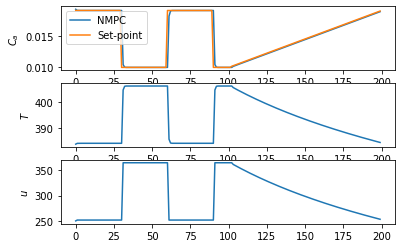

In [14]:
ax1 = plt.subplot(3, 1, 1)
plt.plot(cal)
plt.plot(spl)
plt.ylabel("$C_{a}$")
plt.legend(["NMPC", "Set-point"])

plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(tl)
plt.ylabel("$T$")


plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(ul)
plt.ylabel("$u$")
#plt.title("Control input")
plt.show()
plt.show()

### Credits:
 - David Thierry  (Carnegie Mellon University)